## Classifying Clapper Rails and King Rails Based on their Kek Calls

This project will analyze acoustic markers derived from audio recordings of Clapper Rails and King Rails in an attempt to classify the species.  
Sample sounds from these calls can be listened to at The Cornell Lab:
 - Clapper Rail Sounds: https://www.allaboutbirds.org/guide/Clapper_Rail/sounds
 - King Rail Sounds: https://www.allaboutbirds.org/guide/King_Rail/sounds

Original work on this dataset is documented at the Wiley Online Library: https://onlinelibrary.wiley.com/doi/10.1002/ece3.4711  
A copy of this research is also included in this git repository as "Ecology and Evolution - 2018 - Stiffler.pdf"

During this analysis we will review the following questions:
 - Can we reproduce the basic findings regarding optimal machine learning models for this classification?
 - Are there improvements that can be made in the outcomes?

https://github.com/carl-schick-ds/rails.git

***
### Setup
Import needed libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from IPython.display import display

***
### Data Collection
Data collection was not required for this project since the original dataset is available online in CSV format and is included in this repository as "KIRACLRA.csv".  
I reached out to the original researches in an attempt to obtain the source audio recordings that were used to produce the audio markers in the dataset, but those recordings are no longer available.  

It's feasible that improvements could be made to the classification model by using different audio markers, but this is beyond the scope of this analysis and, in any regard, is not possible due to the unavailability of the source audio recordings.

### Data Loading and Cleaning

#### Load CSVs
Load the data from the csv files and run a quick review of the data for validity checks

In [58]:
rails_df = pd.read_csv('KIRACLRA.csv')
rails_df.head()

,Species,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),IQR BW (Hz),Freq 5% (Hz),Freq 95% (Hz),BW 90% (Hz)
0,CLRA,"2,601.600","2,437.500","2,976.600",539.100,"1,851.600","4,031.200","2,179.700"
1,CLRA,"2,882.800","2,671.900","3,234.400",562.500,"1,992.200","4,125.000","2,132.800"
2,CLRA,"1,500.000","1,593.800","2,953.100","1,359.400","1,500.000","4,804.700","3,304.700"
3,CLRA,"2,507.800","2,507.800","3,656.200","1,148.400","1,664.100","4,851.600","3,187.500"
4,CLRA,"2,953.100","2,765.600","3,703.100",937.500,"2,015.600","4,453.100","2,437.500"


In [59]:
rails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         960 non-null    object 
 1   Peak Freq (Hz)  960 non-null    float64
 2   Q1 Freq (Hz)    960 non-null    float64
 3   Q3 Freq (Hz)    960 non-null    float64
 4   IQR BW (Hz)     960 non-null    float64
 5   Freq 5% (Hz)    960 non-null    float64
 6   Freq 95% (Hz)   960 non-null    float64
 7   BW 90% (Hz)     960 non-null    float64
dtypes: float64(7), object(1)
memory usage: 60.1+ KB


***
Generate descriptive statistics for both the Clapper Rail and King Rail recordings.  
These were compared back to the original research to confirm we are starting from the same place.
***

In [60]:
print("Clapper Rails Descriptive Statistics")
display(rails_df[rails_df['Species'] == 'CLRA'].describe().round(decimals=0).astype(int))
print("King Rails Descriptive Statistics")
display(rails_df[rails_df['Species'] == 'KIRA'].describe().round(decimals=0).astype(int))

Clapper Rails Descriptive Statistics


,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),IQR BW (Hz),Freq 5% (Hz),Freq 95% (Hz),BW 90% (Hz)
count,480,480,480,480,480,480,480
mean,2824,2482,3284,801,1979,4175,2196
std,520,327,403,392,273,563,639
min,1500,1594,2484,70,1500,2883,773
25%,2578,2291,2930,516,1805,3744,1734
50%,2742,2508,3258,773,1922,4312,2250
75%,3053,2648,3498,1008,2180,4664,2771
max,4852,3539,4664,2344,2812,4969,3398


King Rails Descriptive Statistics


,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),IQR BW (Hz),Freq 5% (Hz),Freq 95% (Hz),BW 90% (Hz)
count,480,480,480,480,480,480,480
mean,2808,2556,3254,698,2096,3997,1901
std,476,309,530,467,333,587,683
min,1550,1572,2304,65,1507,2692,581
25%,2541,2433,2885,388,1809,3467,1351
50%,2756,2562,3112,581,2132,4059,1873
75%,2993,2735,3488,861,2347,4457,2455
max,4802,3316,4802,2778,3036,4974,3424


#### Clean the Data

Confirm the target column, Species, review the counts, rename the values, and reset the column as a categorical type.

In [61]:
## Define our Categorical Dtype in order to ensure the Clapper Species is the positive value during classification
species_cat = CategoricalDtype(categories=['King', 'Clapper'], ordered=True)  

print(rails_df['Species'].value_counts())
rails_df['Species'] = rails_df['Species'].apply(lambda x: 'Clapper' if x == 'CLRA' else 'King')
rails_df['Species'] = rails_df['Species'].astype(species_cat)
print(rails_df['Species'].value_counts())
print()
display(rails_df.info())

CLRA    480
KIRA    480
Name: Species, dtype: int64
King       480
Clapper    480
Name: Species, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Species         960 non-null    category
 1   Peak Freq (Hz)  960 non-null    float64 
 2   Q1 Freq (Hz)    960 non-null    float64 
 3   Q3 Freq (Hz)    960 non-null    float64 
 4   IQR BW (Hz)     960 non-null    float64 
 5   Freq 5% (Hz)    960 non-null    float64 
 6   Freq 95% (Hz)   960 non-null    float64 
 7   BW 90% (Hz)     960 non-null    float64 
dtypes: category(1), float64(7)
memory usage: 53.7 KB


None

***
Review the correlation of the parameters to determine if any parameters can be dropped in order to simply the models.  
Generate both a correlation table and a heatmap.
***

In [62]:
corr = rails_df.corr()
display(corr)

,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),IQR BW (Hz),Freq 5% (Hz),Freq 95% (Hz),BW 90% (Hz)
Peak Freq (Hz),1.000,0.564,0.511,0.138,0.254,0.207,0.061
Q1 Freq (Hz),0.564,1.000,0.450,-0.249,0.630,0.184,-0.130
Q3 Freq (Hz),0.511,0.450,1.000,0.753,0.135,0.593,0.447
IQR BW (Hz),0.138,-0.249,0.753,1.000,-0.317,0.508,0.581
Freq 5% (Hz),0.254,0.630,0.135,-0.317,1.000,-0.068,-0.516
Freq 95% (Hz),0.207,0.184,0.593,0.508,-0.068,1.000,0.890
BW 90% (Hz),0.061,-0.130,0.447,0.581,-0.516,0.890,1.000


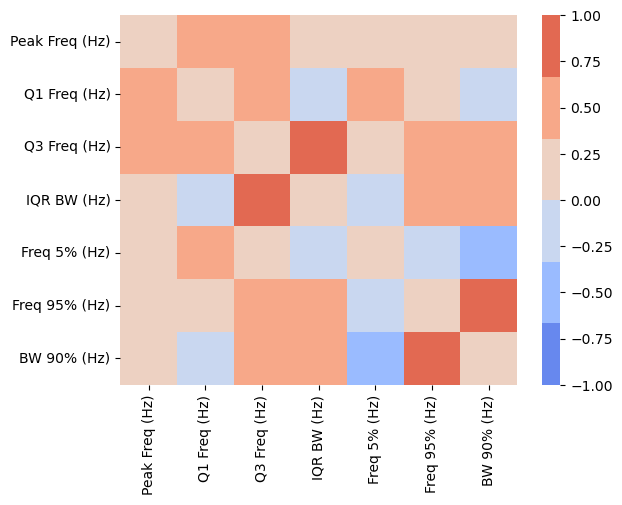

In [63]:
# Set the self-correlation cells (the diaganols) to zero to minimize their prominence during visual review
np.fill_diagonal(corr.values, 0)

# Set the palette to 'coolwarm' and the min/max to the extreme ends of valid correlation values
colormap = sns.color_palette("coolwarm")
vmin, vmax = (-1, 1)

# Display the heatmap
sns.heatmap(corr, center=(vmin + vmax) / 2, vmin=vmin, vmax=vmax, cmap=colormap)
'';

Both the correlation table and the heatmap indicate a strong correlation between the Bandwidth (BW) markers and one of the Frequency ranges.  
Specifically, `IGR BW (Hz)` is highly correlated with `Q3 Freq Hz` (*r* $\approx$ .75) and `BW 90% (Hz)` is highly correlated with `Freq 95% (Hz)` (*r* $\approx$ .89)  

Parameters with correlations above .70 - .75 will have a negligible impact on the model results since their values are appropriately accounted for in another parameter.  At times, their inclusion could actually produce worse outcomes since they can add unnecessary noise to the model generation.  For this reason, we will likely drop both of the Bandwidth (BW) markers from the dataset.  

### Data Exploration

#### Visualize Parameter Realtionships with Species Classification
The relationship of each parameter with the Species classification is visualized in a variety of formats: historgrams, boxplots, violinplots, and scatterplots.

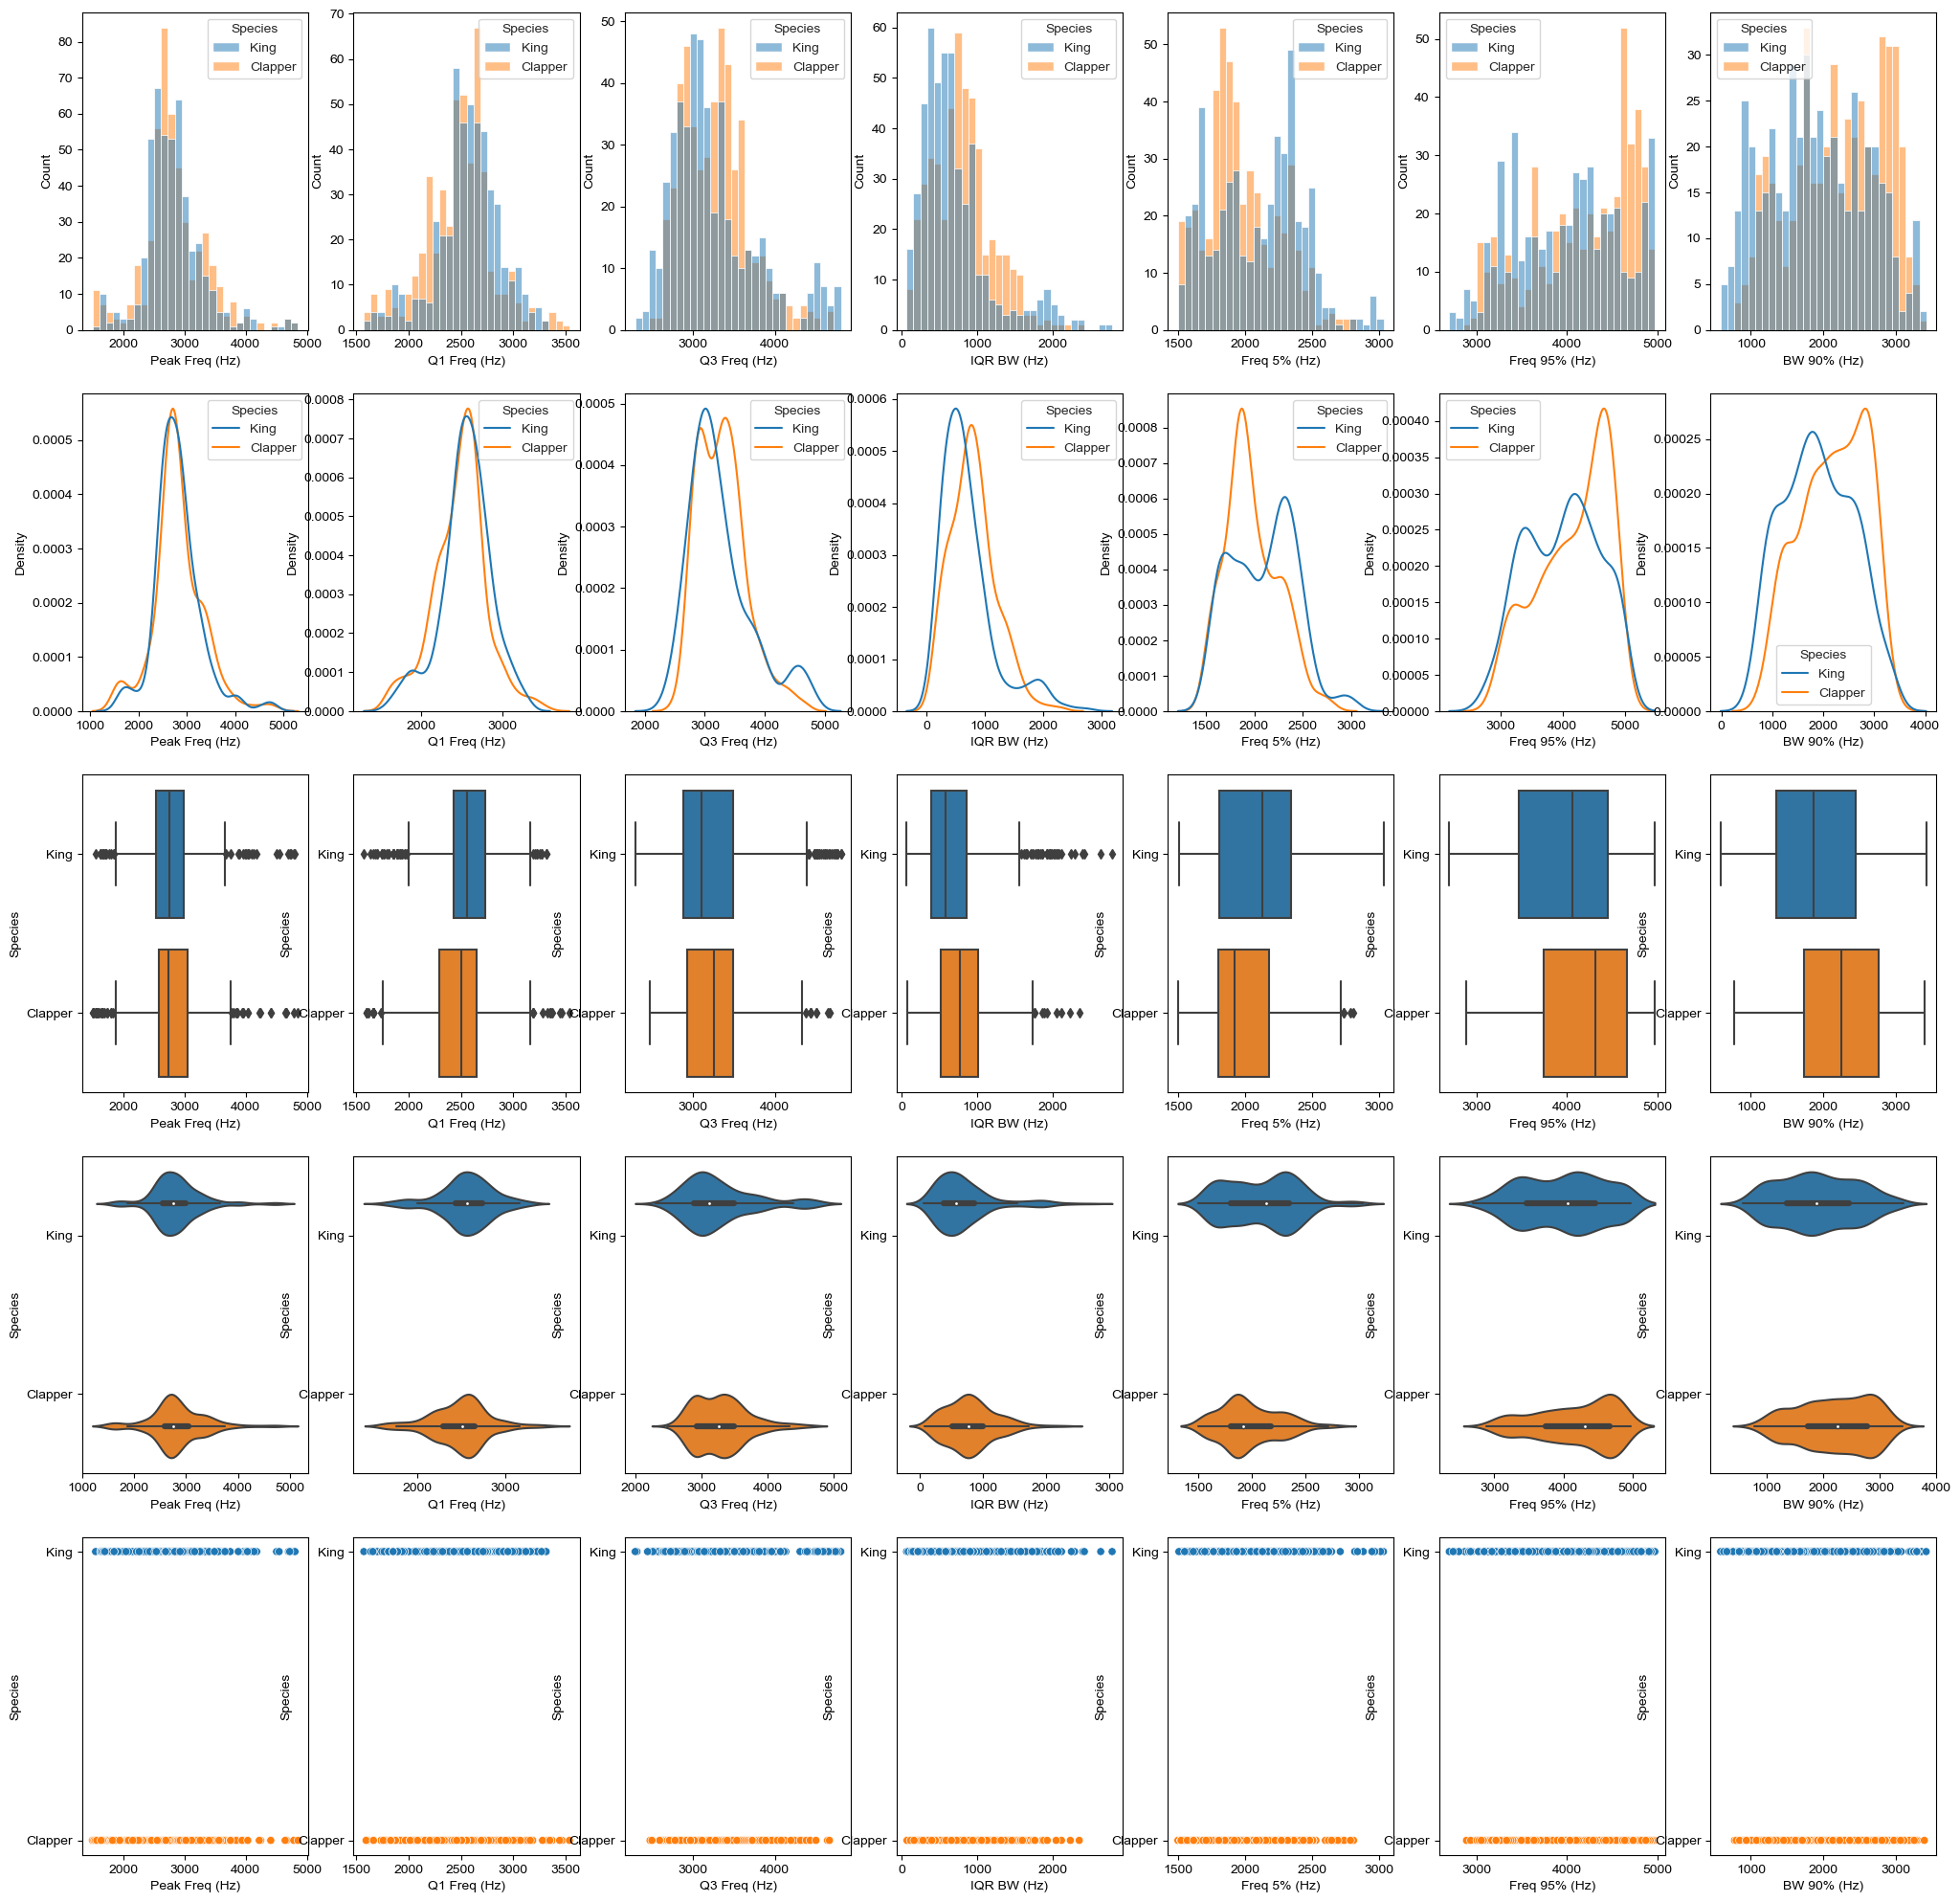

In [64]:
feature_columns = rails_df.drop('Species', axis=1).columns.to_list()

fig, axes = plt.subplots(5,len(feature_columns), figsize=(25,25))
sns.set_style('whitegrid')

for i in range(len(feature_columns)):
    sns.histplot(data=rails_df, x=feature_columns[i], bins = 30, hue='Species', ax=axes[0,i])
    sns.kdeplot(data=rails_df, x=feature_columns[i], hue='Species', ax=axes[1,i])
    sns.boxplot(data=rails_df, x=feature_columns[i], y='Species', ax=axes[2,i])
    sns.violinplot(data=rails_df, x=feature_columns[i], y='Species', hue='Species', legend=False, ax=axes[3,i])
    sns.scatterplot(data=rails_df, x=feature_columns[i], y='Species', hue='Species', legend=False, ax=axes[4,i])

for i in range(len(axes[3])):
    axes[3,i].legend().remove()
'';

As shown in the charts above, there is quite a bit of overlap in the Clapper and King data points.  Since parametric models such as Linear and Quadratic Discriminant Analysis and Logistic Regression depend on the data to follow a limited (fixed) parameter function, it's probable that those models will have a difficult time with the classification.  However, non-parametric models such K-Nearest Neighbors and Support Vector Machines that make no assumptions on the functional form of the data may be able to find a wide range of patterns to help aid a successful classification.  Let's get to it!

### Model Preparation

While not a huge variation in the range of the numeric values for the parameters, it' still a good idea to normalize the data.  
We will use a standard scaler for normalization, where `new_value = (orig_value - mean) / std-dev`.  

**Note: This scaling was not done during the original study and may help with yielding improved results.**

In addition, let's extract the features and target into generic X and y variables.

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(rails_df.drop('Species', axis=1)), columns=rails_df.drop('Species', axis=1).columns)
# X = rails_df.drop('Species', axis=1)
y = rails_df['Species']

***
Split the data into test and train datasets, with 30% reserved for testing.
***

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=77)

***
Import the methods we will use for model evaluation
***

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_curve, auc
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
plt.style.use('default')
pd.options.display.float_format = '{:,.3f}'.format

### Scoring Overview
We will use the same scoring metrics used in the original study.  Specifically, we will track...
 - **Accuracy**: the ratio of correctly predicted observations to the total observations.  `(TP + TN) / (TP + FP + TN + FN)`
 - **Precision**: the ratio of correctly predicted positive observations to the total predicted positive observations.  `TP / (TP + FP)`
 - **Sensitivity**: the ratio of correctly predicted positive observations to the total actual positive observations.  `TP / (TP + FN)`
 - **Specificity**: the ratio of correctly predicted negative observations to the total actual negative observations.  `TN / (TN + FP)`
 - **Area Under the Curve (AUC)**: estimated area under the `ROC curve`.  Used as a general measure of aggregated classification performance. 
 - **Cohen's kappa (*K*)**: similar to Accuracy, but takes into account the possibility of the classification happening by chance.

Reference Notes:  
 - `TP`: True Positive (correctly classified a Clapper rail as a Clapper rail)
 - `TN`: True Negative (correctly classified a King rail as a King rail)
 - `FP`: False Positive, Type I error (incorrectly classified a King rail as a Clapper rail)
 - `FN`: False Negative, Type II error (incorrectly classified a Clapper rail as a King rail)
 - `TPR`: True Positive Rate (the ratio of True Positives (`TP`) to the total actual positive observations; equal to Sensitivity)
 - `FPR`: False Positive Rate (the ratio of False Positives (`FP`) to the total actual negative observations; equal to 1 - Specificity)
 - `ROC curve`: graphical plot of the True Positive Rate (`TPR`) against the False Positive Rate (`FPR`) at various threshold settings (ranging 0.0 - 1.0)
<br><br>
 - Sensitivity is equal to the Recall of the positive class (Clapper)  
 - Specificity is equal to the Recall of the negative class (King)  

The outcomes from the original study are shown in the image below.

![](orig_outcomes.jpg)

### Model Selection

#### Parametric Models

***
Helper Functions
***

In [68]:
def split_data(X, y, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)
    return X_train, X_test, y_train, y_test

def train_model(model, X, y):
    model.fit(X, y)

def test_model(model, X, y):
    # Make pedictions
    predictions = model.predict(X)

    # Get predicted probabilities
    # Although Clapper is the positive class, it's the first class returned by predict_proba
    y_pred_proba = model.predict_proba(X)
    y_pred_proba_Clapper = y_pred_proba[::,0]
    y_pred_proba_King = y_pred_proba[::,1]

    # Calculate scores
    class_rpt = classification_report(y, predictions, output_dict=True)
    fpr, tpr, thresholds = roc_curve(y,  y_pred_proba_Clapper, pos_label='Clapper')
    scr_accuracy = class_rpt['accuracy']
    scr_precision = class_rpt['Clapper']['precision']
    scr_sensitivity = class_rpt['Clapper']['recall']
    scr_specificity = class_rpt['King']['recall']
    scr_auc = auc(fpr, tpr)
    scr_k = cohen_kappa_score(y, predictions)

    scores = [scr_accuracy, scr_precision, scr_sensitivity, scr_specificity, scr_auc, scr_k]
    cm = confusion_matrix(y, predictions)
    
    return scores, cm

***
Linear Discriminant Analysis, Quadratic Discriminant Analysis, and Logistic Regression
***

In [69]:
def test_parameter_models(X, y, iterations=1, partial=True, scaled=True, display_results=False):
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
    from sklearn.linear_model import LogisticRegression

    ldr = LinearDiscriminantAnalysis()
    qdr = QuadraticDiscriminantAnalysis()
    lr = LogisticRegression()

    param_models = {'Linear DFA': ldr, 'Quadratic DFA': qdr, 'Logistic Regression': lr}

    results_cols = ['Iterations', 'Features', 'Class', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'AUC', 'K']
    features_desc = 'All Unscaled' if not partial and not scaled else 'All Scaled' if not partial and scaled else 'Partial Scaled' if partial and scaled else 'Partial Unscaled'
    model_results = pd.DataFrame(columns=results_cols)
    model_cms = {}

    for model_name, model in param_models.items():
        agg_scores = []
        agg_cm = []

        for i in range(iterations):
            X_train, X_test, y_train, y_test = split_data(X, y)
            train_model(model, X_train, y_train)
            iter_scores, iter_cm = test_model(ldr, X_test, y_test)
            agg_scores.append(iter_scores)
            agg_cm.append(iter_cm)

        avg_scores = np.round(np.array(agg_scores).mean(axis=0), decimals=3)
        avg_cm = np.array(agg_cm).mean(axis=0)

        model_results.loc[model_name] = [iterations, features_desc, 'N'] + list(avg_scores)
        model_cms[model_name] = avg_cm

    model_results.sort_values(by='Accuracy', ascending=False, inplace=True)

    if display_results:
        display(model_results)

        num_cms = len(model_results)
        fig, axes = plt.subplots(1, num_cms, figsize=(4*num_cms,3))
        fig.tight_layout(h_pad=5, w_pad=5)
        colormap = sns.color_palette("hls", 4)
        vmin, vmax = (0, 288)

        for index, model_name in enumerate(model_results.index):
            sns.heatmap(model_cms[model_name], center=(vmin + vmax) / 2, vmin=vmin, vmax=vmax, cmap=colormap, annot=True, fmt='.3f', ax=axes[index])
            axes[index].set_xticklabels(['Clapper', 'King'])
            axes[index].set_yticklabels(['Clapper', 'King'])
            axes[index].set_xlabel('Predicted Label')
            axes[index].set_ylabel('True Label')
            axes[index].set_title(model_name)

    return model_results
'';

***
Master Parameters
***

In [70]:
y = rails_df['Species']

X_all = rails_df.drop('Species', axis=1)  # All unscaled features
X_partial = X_all.drop(['IQR BW (Hz)', 'BW 90% (Hz)'], axis=1)  # Reduced unscaled features

X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns)  # All scaled features
X_partial_scaled = pd.DataFrame(scaler.fit_transform(X_partial), columns=X_partial.columns)  # Reduced scaled features


In [71]:
run_results = []
run_results.append(test_parameter_models(X_all, y, iterations=10, partial=False, scaled=False, display_results=False))
run_results.append(test_parameter_models(X_all, y, iterations=100, partial=False, scaled=False, display_results=False))
run_results.append(test_parameter_models(X_all, y, iterations=1000, partial=False, scaled=False, display_results=False))

run_results.append(test_parameter_models(X_partial, y, iterations=10, partial=True, scaled=False, display_results=False))
run_results.append(test_parameter_models(X_partial, y, iterations=100, partial=True, scaled=False, display_results=False))
run_results.append(test_parameter_models(X_partial, y, iterations=1000, partial=True, scaled=False, display_results=False))

run_results.append(test_parameter_models(X_all_scaled, y, iterations=10, partial=False, scaled=True, display_results=False))
run_results.append(test_parameter_models(X_all_scaled, y, iterations=100, partial=False, scaled=True, display_results=False))
run_results.append(test_parameter_models(X_all_scaled, y, iterations=1000, partial=False, scaled=True, display_results=False))

run_results.append(test_parameter_models(X_partial_scaled, y, iterations=10, partial=True, scaled=True, display_results=False))
run_results.append(test_parameter_models(X_partial_scaled, y, iterations=100, partial=True, scaled=True, display_results=False))
run_results.append(test_parameter_models(X_partial_scaled, y, iterations=1000, partial=True, scaled=True, display_results=False))

all_results = pd.concat(run_results)
all_results.sort_values(by='Accuracy', ascending=False, inplace=True)
display(all_results)


,Iterations,Features,Class,Accuracy,Precision,Sensitivity,Specificity,AUC,K
Quadratic DFA,10,Partial Scaled,N,0.596,0.567,0.668,0.528,0.632,0.194
Logistic Regression,10,Partial Scaled,N,0.594,0.584,0.656,0.532,0.638,0.188
Quadratic DFA,10,Partial Unscaled,N,0.585,0.594,0.610,0.559,0.635,0.169
Logistic Regression,10,Partial Unscaled,N,0.584,0.578,0.617,0.552,0.629,0.169
Logistic Regression,100,Partial Scaled,N,0.579,0.576,0.613,0.545,0.630,0.158
Quadratic DFA,100,Partial Scaled,N,0.578,0.575,0.607,0.547,0.629,0.154
Quadratic DFA,100,All Unscaled,N,0.578,0.588,0.531,0.626,0.636,0.156
Logistic Regression,1000,Partial Scaled,N,0.578,0.574,0.608,0.549,0.632,0.156
Linear DFA,10,All Unscaled,N,0.576,0.563,0.593,0.560,0.634,0.152
Logistic Regression,1000,All Unscaled,N,0.576,0.572,0.593,0.559,0.629,0.152


#### Parametric CV Test

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate

## LDR
ldr_cv = LinearDiscriminantAnalysis()
precision_scorer = make_scorer(precision_score, pos_label='Clapper')
sensitivity_scorer = make_scorer(recall_score, pos_label='Clapper')
specificity_scorer = make_scorer(recall_score, pos_label='King')
# auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
k_scorer = make_scorer(cohen_kappa_score)
scoring = {'accuracy': 'accuracy',
            'precision': precision_scorer,
            'sensitivity': sensitivity_scorer,
            'specificity': specificity_scorer,
            'auc': 'roc_auc',
            'k': k_scorer}

scores = cross_validate(ldr_cv, X, y, scoring=scoring, cv=10)
scr_accuracy = round(scores['test_accuracy'].mean(), 3)
scr_precision = round(scores['test_precision'].mean(), 3)
scr_sensitivity = round(scores['test_sensitivity'].mean(), 3)
scr_specificity = round(scores['test_specificity'].mean(), 3)
scr_auc = round(scores['test_auc'].mean(), 3)
scr_k = round(scores['test_k'].mean(), 3)


results_cols = ['Class', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'AUC', 'K']
ldrcv_results = pd.DataFrame(columns=results_cols)
ldrcv_results.loc['Linear DFA - CV'] = ['N', scr_accuracy, scr_precision, scr_sensitivity, scr_specificity, scr_auc, scr_k]
display(ldrcv_results)

,Class,Accuracy,Precision,Sensitivity,Specificity,AUC,K
Linear DFA - CV,N,0.568,0.570,0.562,0.573,0.627,0.135


In [17]:
display(pd.concat([model_results, ldrcv_results]).sort_values(by='Accuracy', ascending=False))

,Class,Accuracy,Precision,Sensitivity,Specificity,AUC,K
Quadratic DFA,N,0.579,0.583,0.554,0.604,0.631,0.158
Logistic Regression,N,0.579,0.583,0.554,0.604,0.631,0.158
Linear DFA - CV,N,0.568,0.570,0.562,0.573,0.627,0.135
Linear DFA,N,0.565,0.568,0.562,0.572,0.623,0.133


#### Non-Parametric Models